# Experiment Platy reconstruction
- 18 keV
- 'Platy' sample
- distances (motors): 136 140 146 155
- distances (real): 61 65 71 80 mm
- 40x objective: pixel = 0.1625 nm

In [1]:
import os
# os.environ['OMP_NUM_THREADS'] ='1'
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
# os.environ['MKL_NUM_THREADS'] = '1'
#os.system('taskset -cp 0-100 %d' % os.getpid())

import sys, time
import dxchange, tomopy
import numpy as np
import tifffile
from scipy.ndimage import rotate
from contextlib import closing
from multiprocessing import Pool
import gc
from maximus48 import monochromaticCTF as CTF 

from maximus48 import var
from maximus48 import SSIM_131119 as SSIM_sf 
from maximus48 import multiCTF2 as multiCTF
from maximus48.SSIM_131119 import SSIM_const 
from maximus48.tomo_proc3 import (Processor, F, tonumpyarray, rotscan)
from maximus48 import FSC

from pybdv import make_bdv 

import dask
import dask.array as da
from dask.array.image import imread

from dask.distributed import Client, progress

from dask_jobqueue import SLURMCluster
import os



astropy module not found


### Sample list

###### 40x objective (0.1625um pixel) | ROI | distances:

In [2]:
%cd /g/emcf/schorb/data/HH_tardi

%ls *_00001.tiff


/g/emcf/schorb/data/HH_tardi
ls: cannot access *_00001.tiff: No such file or directory


Useful data:
- ...

In [3]:
folder = '/g/emcf/schorb/data/HH_tardi/pin1/mid1/'
folder_result = '/g/emcf/schorb/data/HH_tardi/pin1/mid1/rec1/'
data_name = 'x'

file = folder + data_name + '_1_00001.tiff'
ROI = (100,100,1900,1900)
#ROI = (0,100,2048,2048)

distances = (1,2,3,4)
N_distances  = 4      


image = var.read_image(file, ROI = ROI)
# var.show(image)

# =============================================================================
#  initialize parameters for phase retrieval with CTF
# =============================================================================
N_steps = 10                                                                   # Number of projections per degree
N_start = 1                                                                    # index of the first file
N_finish = 3600                                                                # index of the last file

pixel = 0.1625 * 1e-6                                                          # pixel size 
distance = np.array((6.1, 6.5, 7.1, 8), dtype = 'float32') * 1e-2              # distances of your measurements 
energy = 18                                                                    # photon energy in keV
beta_delta = 0.15
zero_compensation = 0.05
ROI = (0,100,2048,2048)                                                        # ROI of the image to be read (x,y,x1,y1 at the image - inverse to numpy!)
cp_count = 80                                                                 # number of cores for multiprocessing
inclination = -0.23    

wavelength = var.wavelen(energy)
fresnelN = pixel**2/(wavelength*distance)

print(fresnelN)

[0.00628468 0.00589793 0.00539951 0.00479207]


## Align distances

In [4]:
# =============================================================================
# fft image and average over all angles
# =============================================================================
if (image.shape[0] != image.shape[1]):
    raise Exception('The image is not square. Please make it square and try again')
#var.show(image)

im = fft2(image)
im = np.log(abs(fftshift(im)))
var.show(im)

NameError: name 'fft2' is not defined

If the there are rings, this means that CTF function (and phase contrast) is there. Normally 1-2 rings is already a good catch.

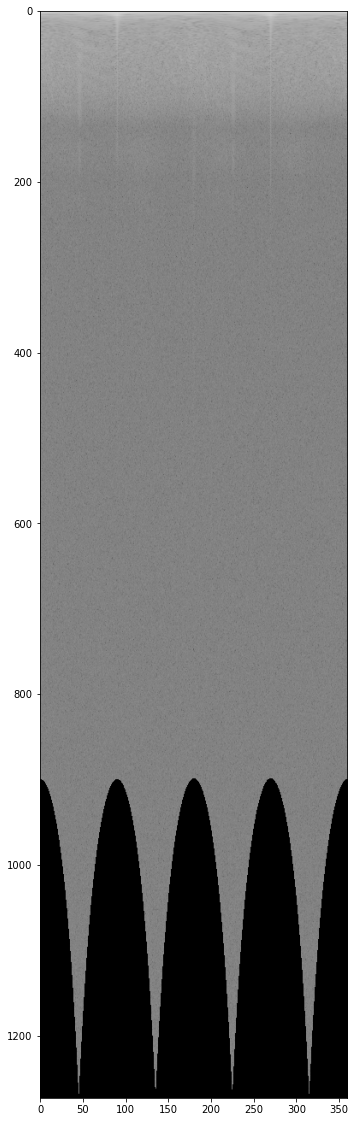

In [20]:
# reproject to polar coordinates
im = polar_image().reproject_image_into_polar(im)[:,:,0]
var.show(im)

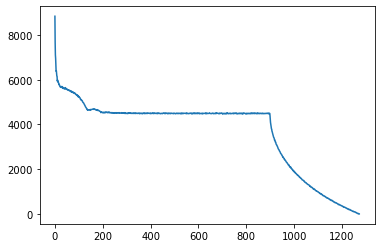

In [21]:
# sum over all angles
im = np.sum(im, axis = 1)
#im = polar_image().baseline(im)
plt.plot(im)

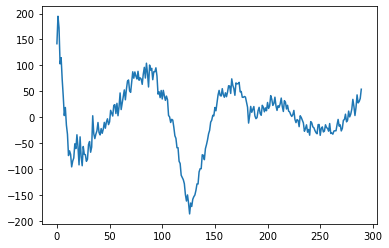

In [22]:
# pick only meaningful region
a = 10
b = 300

data = im[a:b]

# substract the baseline
data = polar_image().baseline(data)

plt.plot(data)

In [7]:
# =============================================================================
# spline fit the curve
# =============================================================================
x = np.linspace(0, data.shape[0], len(data), dtype = 'uint16')
y = data
    
pfit = np.polyfit(x, y, 40)                         # returns polynomial coefficients
yp = np.polyval(pfit, x)                            # fits the curve,

plt.plot(data)
plt.plot(yp)
plt.show()

NameError: name 'data' is not defined

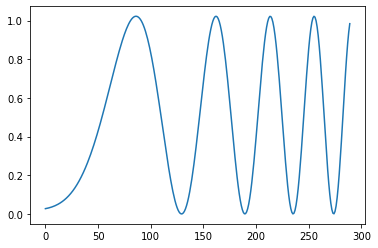

In [14]:
# =============================================================================
# calculate theoretical CTF
# =============================================================================
distance = 6.1 * 1e-2                                      # distance in m
fresnelN0 = pixel**2/(wavelength*distance)

CTF_theory = CTF.CTF_function(image, fresnelN0, beta_delta =0.15)
plt.plot(CTF_theory[a:b])

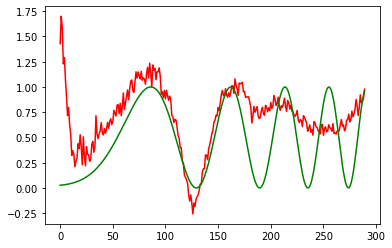

In [25]:
#### plot both together

# =============================================================================
# prepare the plot 
# =============================================================================

scale_a = data
#scale_a = yp
scale_b = CTF_theory[a:b]

scale_a = scale_a/np.max(scale_a) + 0.7#0.6
scale_b = scale_b/np.max(scale_b)

# =============================================================================
# find local minima of both functions and plot result
# =============================================================================
min_a = argrelextrema(scale_a, np.less)  #np.greater or np.less
min_b = argrelextrema(scale_b, np.less)

plt.plot(scale_a, 'r')
plt.plot(scale_b, 'g')
#plt.legend(('minima_exp='+str(min_a),'minima_theor='+str(min_b)))
plt.show()


##### Tune distances and delta/beta to make two curves fit. Note:
    - delta/beta change moves the curve parallel. 
    - Distance change moves it parallel + changes the distance between minima.
    
You may use raw data or interpolated plot for the comparison with theoretical CTF. 


## See if the result looks good

In [34]:
# =============================================================================
#  initialize parameters for phase retrieval with CTF
# =============================================================================
pixel = 0.1625 * 1e-6                                                        # pixel size 
distance = 6.1 * 1e-2                                                         # distances for your measurements
energy = 18                                                                 # photon energy in keV
beta_delta = 0.2
zero_compensation = 0.05
Npad = 200                                                                  # number to pad before phase retrieval
# Npad = image.shape[0]//4

wavelength = var.wavelen(energy)
fresnelN0 = pixel**2/(wavelength*distance)

0.006284678500155383


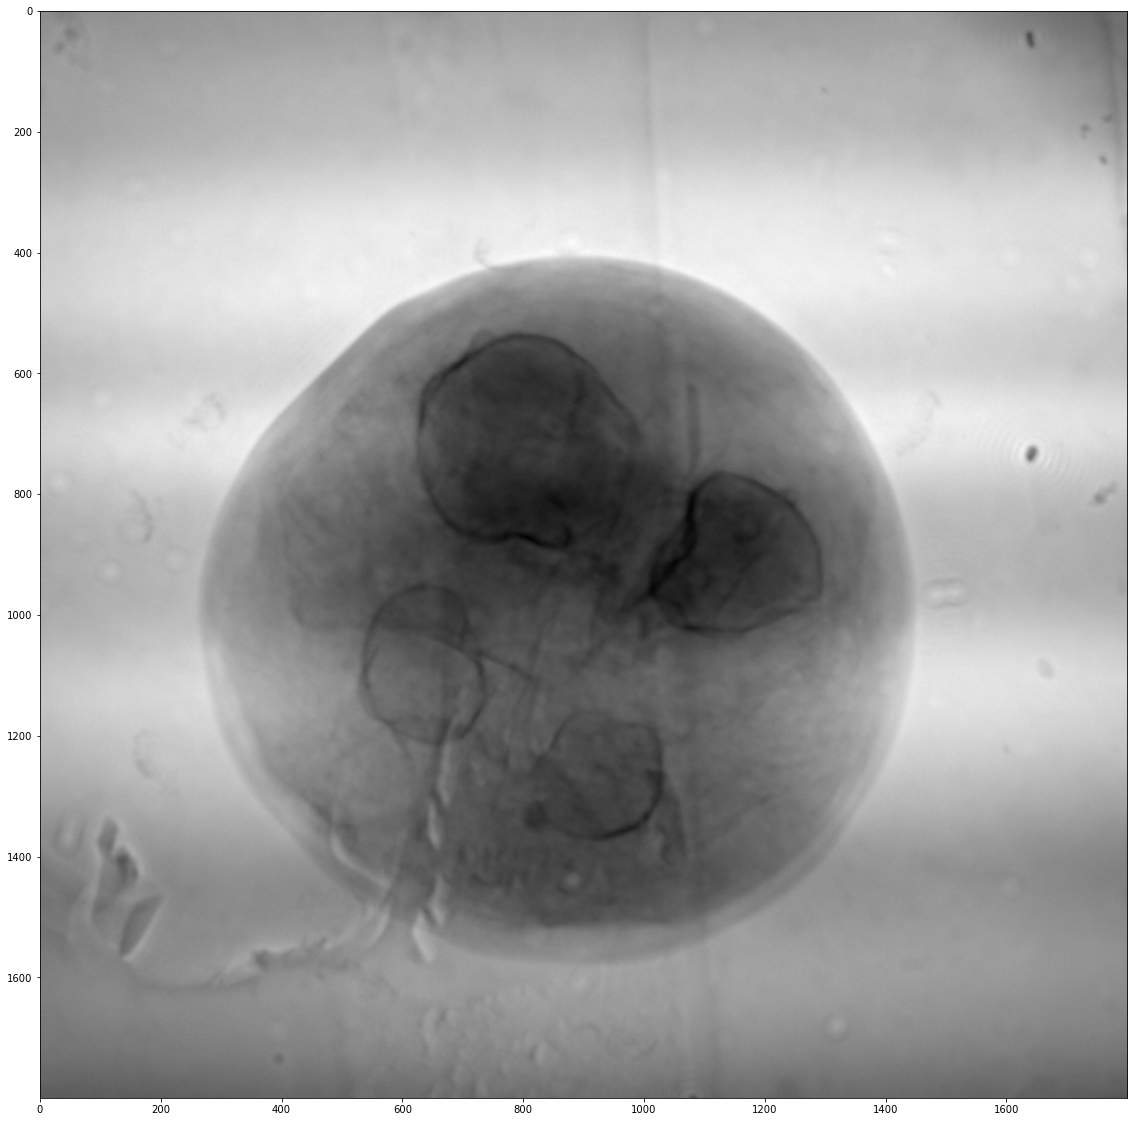

In [9]:
# =============================================================================
# # CTF retrieval 
# =============================================================================
# pad with border values
filt = np.pad(image, ((Npad, Npad),(Npad, Npad)), 'edge')

# calculate CTF
test_CTF = CTF.single_distance_CTF(filt, beta_delta, fresnelN0, zero_compensation)

# unpad
test_CTF = test_CTF[Npad:test_CTF.shape[0]-Npad,Npad:test_CTF.shape[1]-Npad]

# show
var.show(test_CTF)


##### Looks reasonable. 
We may try to proceed like that. If the tomogram will look bad => you may try to reduce delta/beta to get more phase retrieval effect. Tune zero_compensation if you are not happy with stron CTF-artifacts (high-frequency aliasing). I typically choose the number between 0.01 (no filter) and 0.01 (slightly blurred).



## GO

Start the processing


In [3]:
# =============================================================================
#    prepartion work 
# =============================================================================
print('\n##################################################################\n',
      data_name, "started with %d cpus on" % cp_count, time.ctime(),
      '\n##################################################################\n')
time1 = time.time()


worker_cpu = 4

workers_per_job = 2


cluster = SLURMCluster(
    cores=worker_cpu * workers_per_job,
    processes=workers_per_job,
    memory="32GB",
    shebang='#!/usr/bin/env bash',
    walltime="00:30:00",
    local_directory='/tmp',
    death_timeout="15s")



##################################################################
 Platy-12601 started with 80 cpus on Thu Mar 18 14:17:30 2021 
##################################################################



In [9]:
cluster.scale(1)

cluster.close()

In [7]:
client = Client(cluster)


In [4]:
maxnodes = 10

ca = cluster.adapt(
    minimum = workers_per_job, maximum=maxnodes * workers_per_job,
    #target_duration="360s",  # measured in CPU time per worker
                             # -> 30 seconds at 12 cores / worker
    scale_factor=1.0  # prevent from scaling up because of CPU or MEM need
)


In [5]:
#calculate parameters for phase-retrieval
wavelength = var.wavelen(energy)
fresnelN = pixel**2/(wavelength*distance)

#create save folder if it doesn't exist
if not os.path.exists(folder_result):
    os.makedirs(folder_result)


# create a class to store all necessary parameters for parallelization
Pro = Processor(ROI, folder, N_start, N_finish, compNpad = 8)                 

#set proper paths
Pro.init_paths(data_name, folder, distances) 

#allocate memory to store flatfield
shape_ff = (N_distances, len(Pro.flats[0]), Pro.im_shape[0], Pro.im_shape[1]) 

a=(len(Pro.flats[0]), Pro.im_shape[0], Pro.im_shape[1])

ff_l =[]

for i in range(N_distances):
    fname = Pro.flats[i][0].rsplit('_00')[0]
    ff_l.append(imread(fname+'*')[:,ROI[1]:ROI[3], ROI[0]:ROI[2]])
    
ff = da.stack(ff_l)


#calculate ff-related constants
Pro.ROI_ff = (ff.shape[3]//4, ff.shape[2]//4,3 * ff.shape[3]//4, 3 * ff.shape[2]//4)    # make ROI for further flatfield and shift corrections, same logic as for normal ROI
ff_con = np.zeros(N_distances, 'object')                                                # array of classes to store flatfield-related constants


indexes_shape = (N_finish - N_start, N_distances)

shifts_shape = (N_finish - N_start, N_distances, 2)

proj_shape = (Pro.N_files, shape_ff[2], shape_ff[3] + 2*Pro.Npad)

ff_shape = (N_distances, len(Pro.flats[0]), Pro.im_shape[0], Pro.im_shape[1]) 



for i in np.arange(N_distances):    
    ff_con[i] = SSIM_const(ff[i][:,Pro.ROI_ff[1]:Pro.ROI_ff[3], 
                                   Pro.ROI_ff[0]:Pro.ROI_ff[2]].transpose(1,2,0))

In [8]:
def read_flat(j,Pro): 
    
    """
    j: int
        an index of the file that should be processed 
    Please note, j always starts from zero
    To open correct file, images array uses images[i][j + N_start-1]
    """

    
    ROI_ff = Pro.ROI_ff
    ROI = Pro.ROI
    images = Pro.images
    N_start = Pro.N_start
    Npad = Pro.Npad
     
    #read image and do ff-retrieval    
    filt = []
        
    imnames = images[0][j].partition('_'+str(distances[0])+'_')[0]+'_*_'+'{:05d}'.format(1)+'.'+images[0][j].partition('.')[-1]
    
    im = imread(imnames)[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]
    maxcorridx = []
    
    filts = []
    
    for i in np.arange(len(images)):        
        maxcorridx=(dask.delayed(np.argmax)(SSIM_sf.SSIM(SSIM_const(im[i][ROI_ff[1]:ROI_ff[3], ROI_ff[0]:ROI_ff[2]]), 
                                        ff_con[i]).ssim()))
        
        filts.append(im[i]/ff[i][maxcorridx.compute()])
    
    filt = da.stack(filts)
    
    im_gau0 = var.filt_gauss_laplace(filt[0][ROI_ff[1]:ROI_ff[3], ROI_ff[0]:ROI_ff[2]],
                                    sigma = 5)
    thisshift = []
    
    for i in range(len(filt)):
        im_gau1 = dask.delayed(var.filt_gauss_laplace)(filt[i][ROI_ff[1]:ROI_ff[3], ROI_ff[0]:ROI_ff[2]],
                                    sigma = 5)
        thisshift.append(dask.delayed(var.shift_distance)(im_gau0, im_gau1, 10))
    
    
    filt0 = dask.delayed(multiCTF.shift_imageset)(filt, thisshift)

    filt0 = dask.delayed(np.pad)(filt0, ((0,0),(Npad, Npad),(Npad, Npad)), 'edge')               # padding with border values
    filt0 = dask.delayed(multiCTF.multi_distance_CTF)(filt0, beta_delta, 
                                          fresnelN, zero_compensation)
    filt0 = filt0[Npad:(filt0.shape[0]-Npad),:]
    
    return da.from_array(filt0.compute())
    
    
    

In [ ]:
res = []
for tilt in range(120):
    res.append(dask.delayed(read_flat)(tilt,Pro))
    

results = dask.compute(*res)

distributed.core - ERROR - Exception while handling op workers_to_close
Traceback (most recent call last):
  File "/g/emcf/software/python/miniconda/envs/xtomo/lib/python3.8/site-packages/distributed/core.py", line 496, in handle_comm
    result = handler(comm, **msg)
TypeError: workers_to_close() got an unexpected keyword argument 'scale_factor'
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f84e8ca16d0>>, <Task finished name='Task-166479' coro=<AdaptiveCore.adapt() done, defined at /g/emcf/software/python/miniconda/envs/xtomo/lib/python3.8/site-packages/distributed/deploy/adaptive_core.py:179> exception=TypeError("workers_to_close() got an unexpected keyword argument 'scale_factor'")>)
Traceback (most recent call last):
  File "/g/emcf/software/python/miniconda/envs/xtomo/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  Fi

In [ ]:
    
    #set local variables
    ff = tonumpyarray(ff_shared.shared_array_base, ff_shared.shape, ff_shared.dtype)
    proj_loc = tonumpyarray(proj.shared_array_base, proj.shape, proj.dtype)
    shift = tonumpyarray(shifts.shared_array_base, shifts.shape, shifts.dtype)
    #LoI = tonumpyarray(indexes.shared_array_base, indexes.shape, indexes.dtype)    

    #save to memory
    proj_loc[j] = filt    
    #print('sucessfully processed file: ', images[0][j + N_start-1])                                   # unpad images from the top
        

In [ ]:
# =============================================================================
# Process projections
# =============================================================================
    
#do phase retrieval
time1 = time.time()
with closing(Pool(cp_count, initializer = init)) as pool:    
    pool.map(read_flat, np.arange(Pro.N_files)) 
print('time for ff+shifts: ', time.time()-time1)